# Morphing images generated by VAE
Typically we perform gradient descent on the weights of our model in order to best approximate the posterior distribution. Still, using automatic differentiation tools in deep learning libraries it's easy to find the gradient between *any* two tensors. Here we perform a gradient update on the encoded represenation of a trained VAE in order to generate images that lie "between" two images in our encoded vector space.

Here I'm able to demonstrate that gradient descent on the cross entropy between an image generated from a VAE and a second image with respect to the original image's encoding is sufficient to converge to the second image's encoding. 

The intermediate steps of the gradient descent are steps in vector space between two images. If the images belong to categories (like digits), we can potentially use these intermediate steps to define boundaries in our latent encoded space and improve a classification model by either generating extra data (supervised learning)

## From OpenAI: 
Learned Data Augmentation. You could use a learned VAE of data, to perform “learned data augmentation”. One would first train a VAE on input data, then each training point would be transformed by encoding to a latent space, then applying a simple (e.g. Gaussian) perturbation in latent space, then decoding back to observed space. Could we use such an approach to obtain improved generalization? A potential benefit of such data augmentation is that it could include many nonlinear transformations like viewpoint changes and changes in scene lightning. Can we approximate the set of transformations to which the label is invariant? 

* improved generalization
* set of transformations to which the label is invariant

In [3]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from datetime import datetime

In [4]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples[:16]):
        sample = np.array(sample)
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    plt.show()

    return #fig

In [6]:
class batch_norm(object):
    """Code modification of http://stackoverflow.com/a/33950177"""
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum

            self.ema = tf.train.ExponentialMovingAverage(decay=self.momentum)
            self.name = name

    def __call__(self, x, train=True):
        shape = x.get_shape().as_list()

        if train:
            with tf.variable_scope(self.name) as scope:
                self.beta = tf.get_variable("beta", [shape[-1]],
                                    initializer=tf.constant_initializer(0.))
                self.gamma = tf.get_variable("gamma", [shape[-1]],
                                    initializer=tf.random_normal_initializer(1., 0.02))

                batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
                ema_apply_op = self.ema.apply([batch_mean, batch_var])
                self.ema_mean, self.ema_var = self.ema.average(batch_mean), self.ema.average(batch_var)

                with tf.control_dependencies([ema_apply_op]):
                    mean, var = tf.identity(batch_mean), tf.identity(batch_var)
        else:
            mean, var = self.ema_mean, self.ema_var

        normed = tf.nn.batch_norm_with_global_normalization(
                x, mean, var, self.beta, self.gamma, self.epsilon, scale_after_normalization=True)

        return normed

# standard convolution layer
def conv2d(x, inputFeatures, outputFeatures, name):
    with tf.variable_scope(name):
        w = tf.get_variable("w",[5,5,inputFeatures, outputFeatures], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b",[outputFeatures], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(x, w, strides=[1,2,2,1], padding="SAME") + b
        return conv

def conv_transpose(x, outputShape, name):
    with tf.variable_scope(name):
        # h, w, out, in
        w = tf.get_variable("w",[5,5, outputShape[-1], x.get_shape()[-1]], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable("b",[outputShape[-1]], initializer=tf.constant_initializer(0.0))
        convt = tf.nn.conv2d_transpose(x, w, output_shape=outputShape, strides=[1,2,2,1])
        return convt

def deconv2d(input_, output_shape,
             k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
             name="deconv2d"):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_h, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))

        deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape, strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        return deconv

# leaky reLu unit
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

# fully-conected layer
def dense(x, inputFeatures, outputFeatures, scope=None, with_w=False):
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [inputFeatures, outputFeatures], tf.float32, tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [outputFeatures], initializer=tf.constant_initializer(0.0))
        if with_w:
            return tf.matmul(x, matrix) + bias, matrix, bias
        else:
            return tf.matmul(x, matrix) + bias

In [7]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [8]:
tf.reset_default_graph()

In [9]:
n_z = 20
batchsize = 32

# ENCODER
X = tf.placeholder(tf.float32, shape=[None, 784])
X_reshape = tf.reshape(X, [-1, 28,28,1])
def encoder(x):
    with tf.variable_scope("encoder"):
        h1 = lrelu(conv2d(x, 1, 16, "d_h1")) # 28x28x1 -> 14x14x16
        h2 = lrelu(conv2d(h1, 16, 32, "d_h2")) # 14x14x16 -> 7x7x32
        h2_flat = tf.reshape(h2,[-1, 7*7*32])
        w_mean = dense(h2_flat, 7*7*32, n_z, "w_mean")
        w_stddev_p = dense(h2_flat, 7*7*32, n_z, "w_stddev")
        w_stddev = tf.nn.softplus(w_stddev_p)
    return w_mean, w_stddev


# DECODER
def decoder(z):
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
        z_develop = dense(z, n_z, 7*7*32, scope='z_matrix')
        z_matrix = tf.nn.relu(tf.reshape(z_develop, [-1, 7, 7, 32]))
        h1 = tf.nn.relu(conv_transpose(z_matrix, [batchsize, 14, 14, 16], "g_h1"))
        h2 = conv_transpose(h1, [batchsize, 28, 28, 1], "g_h2")
        h2 = tf.nn.sigmoid(h2)
    return h2


# Generate samples from a distribution on our encoded mean and standard deviation using reparametrization trick
z_mean, z_stddev = encoder(X_reshape)
samples = tf.random_normal([batchsize, n_z], 0, 1, dtype=tf.float32)
z_code = z_mean + (z_stddev * samples)

# Generate images with our decoder. We will use samples from the random distribution of our code for training
# and the mean for testing
generated_images = decoder(z_code)
gen_mean =  decoder(z_mean)
generated_flat = tf.reshape(generated_images, [-1, 784])
gen_mean_flat = tf.reshape(gen_mean, [-1, 784])


# LOSS: Our loss is the sum of our generation loss and latent loss, representing two distance measures of 
# the accuracy of our reproduction and the encoded distribution's KL-divergence from the multivariate standard 
# normal respectively
generation_loss = -tf.reduce_sum(X * tf.log(1e-8 + generated_flat) + 
                                 (1-X) * tf.log(1e-8 + 1 - generated_flat)
                                 ,1)
latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(1e-8 + tf.square(z_stddev)) - 1,1)
loss = tf.reduce_mean(generation_loss + latent_loss)

# OPTIMIZER: perform a Gradient Descent algorithm to update weights (all trainable variables)
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

In [10]:
# "rotate" the Images so that the second image is in the place of the first
X_off  = tf.concat([X[1:,:], X[:1,:]], axis=0)

In [11]:
# A function that "pushes" the encoded tensor of one image towards the encoding of a target image
def grad_pusher(zmean, target, lambda_):
    gen = decoder(zmean)
    genflat = tf.reshape(gen, [-1, 784])
    loss = -tf.reduce_sum(target * tf.log(1e-8 + genflat) + 
                                 (1-target) * tf.log(1e-8 + 1 - genflat)
                                 ,1)
    grad = tf.gradients(loss, zmean)
    newmean = zmean - grad * tf.constant(lambda_)
    return newmean[0]

In [12]:
zzm = z_mean
tdict = [gen_mean_flat]
mdict = [z_mean]
for i in range(16):
    #zzm = grad_pusher(zzm, X_off, .05)
    mdict.append(grad_pusher(mdict[-1], X_off, .02))
    tdict.append(tf.reshape(decoder(mdict[-1]), [-1,784]))
    

In [13]:
lambda_ = tf.constant(.05)
grad = tf.gradients(generation_pusher, z_mean)[0]
new_mean = z_mean - grad * lambda_

new_generated_images = decoder(new_mean)
new_generated_flat = tf.reshape(new_generated_images, [-1, 784])

NameError: name 'generation_pusher' is not defined

In [14]:
samples_fake = tf.random_normal([32, n_z], 0, 1, dtype=tf.float32)
fake_images = decoder(samples_fake)

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
mb_size = batchsize
for it in range(9000):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, gen_loss, lat_loss = sess.run((optimizer, generation_loss, latent_loss), 
                                     feed_dict={X: X_mb})
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('gen_loss: {:.4}'. format(np.mean(gen_loss)))
        print('lat_loss: {:.4}'.format(np.mean(lat_loss)))
        print(str(datetime.now()))
        print()

Iter: 0
gen_loss: 543.4
lat_loss: 2.14
2018-06-19 23:44:30.544247

Iter: 1000
gen_loss: 92.09
lat_loss: 23.28
2018-06-19 23:44:58.311522

Iter: 2000
gen_loss: 79.35
lat_loss: 24.98
2018-06-19 23:45:23.273635

Iter: 3000
gen_loss: 78.7
lat_loss: 25.09
2018-06-19 23:45:45.695907

Iter: 4000
gen_loss: 80.47
lat_loss: 25.68
2018-06-19 23:46:09.607476

Iter: 5000
gen_loss: 75.42
lat_loss: 25.88
2018-06-19 23:46:35.845893

Iter: 6000
gen_loss: 76.31
lat_loss: 25.59
2018-06-19 23:47:00.504878

Iter: 7000
gen_loss: 81.0
lat_loss: 25.64
2018-06-19 23:47:22.583861

Iter: 8000
gen_loss: 81.96
lat_loss: 25.02
2018-06-19 23:47:46.812554



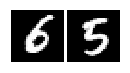

In [35]:
X_mb,_ = mnist.train.next_batch(mb_size)
plot(sess.run(X_reshape, feed_dict={X:X_mb})[:2])
imgs = [sess.run(X_reshape, feed_dict={X:X_mb})]
for t in tdict:
    tt=  sess.run(t , feed_dict={X:X_mb})
    imgs.append(tt)

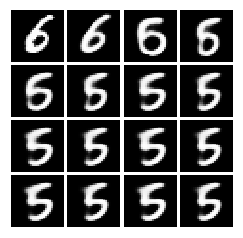

In [36]:
plot(np.array([i[0] for i in imgs]))

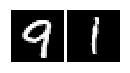

In [37]:
X_mb,_ = mnist.train.next_batch(mb_size)
plot(sess.run(X_reshape, feed_dict={X:X_mb})[:2])
imgs = [sess.run(X_reshape, feed_dict={X:X_mb})]
mmns=[]
for i in range(len(tdict)):
    mm,tt=  sess.run([mdict[i],tdict[i]] , feed_dict={X:X_mb})
    imgs.append(tt)
    mmns.append(mm)
sdf=np.array(mmns)[:,0,:]

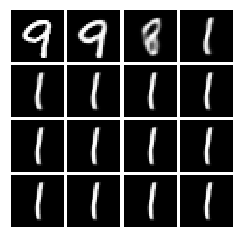

In [38]:
plot(np.array([i[0] for i in imgs]))

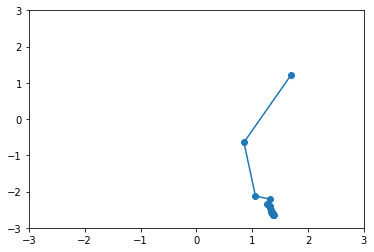

In [39]:
plt.axis([-3,3,-3,3])

plt.scatter(sdf[:,0], sdf[:,1])
plt.plot(sdf[:,0], sdf[:,1])
circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None')
plt.Circle(0,0)


In [121]:
imgs[0].shape

(32, 784)

In [ ]:
t, r, _, _, _ = sess.run([tdict, X_reshape, z_code, z_mean, z_stddev], feed_dict={X: X_mb})
plot(r)
plot(t[0])
plot(t[1])

r


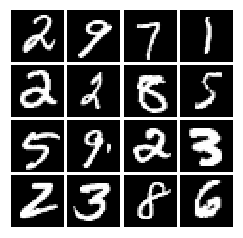

g


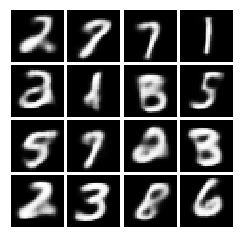

gg


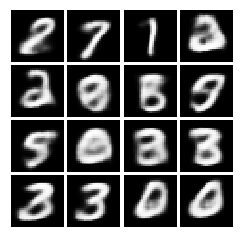

In [107]:
g, gg, r, _, _, _ = sess.run([gen_mean, new_generated_flat, X_reshape, z_code, z_mean, z_stddev], feed_dict={X: X_mb})
print('r')
plot(r)
print('g')
plot(g)
print('gg')
plot(gg)

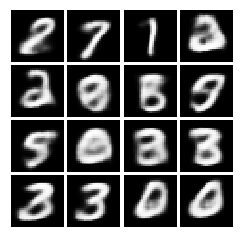

In [100]:
plot(gg)

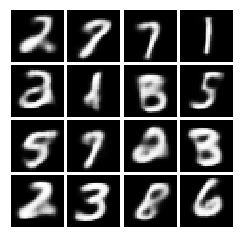

In [105]:
plot(g)